In [1]:
import contextlib

import numpy as np
import numpy.typing as npt
import xarray as xr
from odc.geo.xr import assign_crs

from ocr import catalog
from ocr.risks.fire import generate_wind_directional_kernels
from ocr.utils import geo_sel

In [11]:
default_fillvals = {
    'S1': '\x00',
    'i1': -127,
    'u1': 255,
    'i2': -32767,
    'u2': 65535,
    'i4': -2147483647,
    'u4': 4294967295,
    'i8': -9223372036854775806,
    'u8': 18446744073709551614,
    'f4': 9.969209968386869e36,
    'f8': 9.969209968386869e36,
}


def set_zarr_encoding(
    ds: xr.Dataset,
    codec_config: dict | None = None,
    float_dtype: npt.DTypeLike | None = None,
    int_dtype: npt.DTypeLike | None = None,
    datetime_dtype: npt.DTypeLike | None = None,
    object_dtype: npt.DTypeLike | None = None,
) -> xr.Dataset:
    """Set zarr encoding for each variable in the dataset

    Parameters
    ----------
    ds : xr.Dataset
        Input dataset
    codec_config : dict, optional
        Dictionary of parameters to pass to numcodecs.get_codec.
        The default is {'id': 'zlib', 'level': 1}
    float_dtype : str or dtype, optional
        Dtype to cast floating point variables to
    int_dtype : str or dtype, optional
        Dtype to cast integer variables to
    object_dtype : str or dtype, optional
        Dtype to cast object variables to.
    datetime_dtype : str or dtype, optional
        Dtype to encode numpy.datetime64 variables as.
        Time coordinates are encoded as 'int32' if cf_xarray
        is able to identify the coordinates representing time,
        even if `datetime_dtype` is None.


    Returns
    -------
    ds : xr.Dataset
        Output dataset with updated variable encodings

    Notes
    -----
    The *_dtype parameters can be used to coerce variables into data types
    readable by Zarr implementations in other languages.

    """
    import numcodecs

    ds = ds.copy()

    if codec_config is None:
        codec_config = {'id': 'zlib', 'level': 1}
    compressor = numcodecs.get_codec(codec_config)

    try:
        time_vars = ds.cf.axes.get('T', []) + ds.cf.bounds.get('T', [])
    except AttributeError:
        time_vars = []
    for varname, da in ds.variables.items():
        # remove old encoding
        da.encoding.clear()

        # maybe cast data type
        if np.issubdtype(da.dtype, np.floating) and float_dtype is not None:
            da = da.astype(float_dtype)
            da.encoding['dtype'] = str(float_dtype)
        elif np.issubdtype(da.dtype, np.integer) and int_dtype is not None:
            da = da.astype(int_dtype)
            da.encoding['dtype'] = str(int_dtype)
        elif da.dtype == 'O' and object_dtype is not None:
            da = da.astype(object_dtype)
            da.encoding['dtype'] = str(object_dtype)
        elif np.issubdtype(da.dtype, np.datetime64) and datetime_dtype is not None:
            da.encoding['dtype'] = str(datetime_dtype)
        elif varname in time_vars:
            da.encoding['dtype'] = 'int32'

        # update with new encoding
        da.encoding['compressor'] = compressor
        with contextlib.suppress(KeyError):
            del da.attrs['_FillValue']
        da.encoding['_FillValue'] = default_fillvals.get(da.dtype.str[-2:], None)

        ds[varname] = da

    return ds

In [12]:
def apply_wind_directional_convolution_with_snapshots(
    da: xr.DataArray,
    iterations: int = 3,
    kernel_size: float = 81.0,
    circle_diameter: float = 35.0,
) -> dict[str, xr.Dataset]:
    """Apply directional convolution with intermediate snapshots for visualization.

    This function mirrors apply_wind_directional_convolution but returns intermediate
    states after each iteration (Q0, Q1, Q2, Q3) for creating methods figure visualizations.

    Parameters
    ----------
    da : xr.DataArray
        The DataArray to apply the convolution to.
    iterations : int, optional
        The number of iterations to apply the convolution, by default 3
    kernel_size : float, optional
        The size of the kernel, by default 81.0
    circle_diameter : float, optional
        The diameter of the circle, by default 35.0

    Returns
    -------
    snapshots : dict[str, xr.Dataset]
        Dictionary with keys 'Q0', 'Q1', 'Q2', 'Q3' containing the Dataset state
        after 0, 1, 2, 3 convolution iterations respectively. Each Dataset has
        variables for each direction ('N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW').
    """
    import cv2 as cv

    weights_dict = generate_wind_directional_kernels(
        kernel_size=kernel_size, circle_diameter=circle_diameter
    )

    # Initialize with original data (Q0)
    spread_results = xr.Dataset(
        data_vars={var_name: (da.dims, da.values) for var_name in weights_dict.keys()},
        coords=da.coords,
        attrs=da.attrs,
    )
    for coord in ['spatial_ref', 'crs']:
        if coord in da.coords:
            spread_results = spread_results.assign_coords({coord: da.coords[coord]})

    snapshots = {'Q0': spread_results.copy(deep=True)}

    for direction, weights in weights_dict.items():
        arr = spread_results[direction].values
        nan_mask = np.isnan(arr)
        arr = np.nan_to_num(arr, nan=0.0)

        for iteration_num in range(iterations):
            valid_mask = (arr > 0).astype(np.float32)
            convolved_mask = cv.filter2D(valid_mask, ddepth=-1, kernel=weights)
            convolved_mask = np.where(convolved_mask < 10e-12, 0.0, convolved_mask)
            convolved_arr = cv.filter2D(arr, ddepth=-1, kernel=weights)
            convolved_arr = np.where(convolved_arr < 10e-12, 0.0, convolved_arr)
            arr = np.where(convolved_mask > 0, convolved_arr / convolved_mask, 0.0)

            # Capture snapshot after each iteration
            if f'Q{iteration_num + 1}' not in snapshots:
                snapshot_ds = xr.Dataset(
                    data_vars={
                        var_name: (da.dims, spread_results[var_name].values)
                        for var_name in weights_dict.keys()
                    },
                    coords=da.coords,
                    attrs=da.attrs,
                )
                for coord in ['spatial_ref', 'crs']:
                    if coord in da.coords:
                        snapshot_ds = snapshot_ds.assign_coords({coord: da.coords[coord]})
                snapshots[f'Q{iteration_num + 1}'] = snapshot_ds

        np.testing.assert_equal((arr < 0).sum(), 0)
        arr = np.where(nan_mask, np.nan, arr)
        spread_results[direction] = (da.dims, arr.astype(np.float32))

        # Update the final snapshot with this direction's final result
        for iteration_num in range(iterations):
            snapshots[f'Q{iteration_num + 1}'][direction] = spread_results[direction]

    return snapshots

In [13]:
ds = catalog.get_dataset('conus404-ffwi-p99-wind-direction-distribution-30m-4326').to_xarray()
ds = assign_crs(ds, crs=ds.spatial_ref.attrs['crs_wkt'])
ds

<xarray.Dataset> Size: 652GB
Dimensions:                      (latitude: 97579, longitude: 208881,
                                  wind_direction: 8)
Coordinates:
  * latitude                     (latitude) float64 781kB 22.43 22.43 ... 52.48
  * longitude                    (longitude) float64 2MB -128.4 ... -64.05
    crs                          int64 8B ...
    quantile                     float64 8B ...
    spatial_ref                  int32 4B 4326
Dimensions without coordinates: wind_direction
Data variables:
    wind_direction_distribution  (latitude, longitude, wind_direction) float32 652GB dask.array<chunksize=(6000, 4500, 8), meta=np.ndarray>
Attributes:
    reprojected_to:  scott-et-al-2024-30m-4326

In [14]:
ds.odc.geobox.resolution

Resolution(x=0.000307994, y=0.000307994)

In [15]:
# marshall fire, Colorado
lat = 39.95
lon = -105.15

x_buffer = 50 * ds.odc.geobox.resolution.x
y_buffer = 50 * ds.odc.geobox.resolution.y

# x_buffer = 0.15
# y_buffer = 0.15

buffered_y_slice = slice(lat - y_buffer, lat + y_buffer)
buffered_x_slice = slice(lon - x_buffer, lon + x_buffer)

In [16]:
buffered_x_slice, buffered_y_slice

(slice(-105.16539969392184, -105.13460030607817, None),
 slice(39.93460030607817, 39.96539969392184, None))

In [17]:
riley_2011_30m_4326 = catalog.get_dataset('riley-et-al-2025-2011-30m-4326').to_xarray()[['BP']]
riley_2047_30m_4326 = catalog.get_dataset('riley-et-al-2025-2047-30m-4326').to_xarray()[['BP']]
riley_2011_270m_5070 = catalog.get_dataset('riley-et-al-2025-2011-270m-5070').to_xarray()[
    ['BP', 'spatial_ref']
]
riley_2011_270m_5070 = assign_crs(riley_2011_270m_5070, 'EPSG:5070')
riley_2047_270m_5070 = catalog.get_dataset('riley-et-al-2025-2047-270m-5070').to_xarray()[
    ['BP', 'spatial_ref']
]
riley_2047_270m_5070 = assign_crs(riley_2047_270m_5070, 'EPSG:5070')

rps_30 = catalog.get_dataset('scott-et-al-2024-30m-4326').to_xarray()[['BP', 'CRPS', 'RPS']]

riley_2011_30m_4326_subset = riley_2011_30m_4326.sel(
    latitude=buffered_y_slice, longitude=buffered_x_slice
)
riley_2047_30m_4326_subset = riley_2047_30m_4326.sel(
    latitude=buffered_y_slice, longitude=buffered_x_slice
)

# west, south, east, north = bbox

bbox = (
    buffered_x_slice.start,
    buffered_y_slice.start,
    buffered_x_slice.stop,
    buffered_y_slice.stop,
)
riley_2011_270m_5070_subset = geo_sel(
    riley_2011_270m_5070,
    bbox=bbox,
    crs_wkt=riley_2011_270m_5070.spatial_ref.attrs['crs_wkt'],
).load()
riley_2047_270m_5070_subset = geo_sel(
    riley_2047_270m_5070,
    bbox=bbox,
    crs_wkt=riley_2047_270m_5070.spatial_ref.attrs['crs_wkt'],
).load()

wind_direction_distribution_30m_4326 = ds.wind_direction_distribution.sel(
    latitude=buffered_y_slice, longitude=buffered_x_slice
).load()

# Step 01: Gap Filling

Progressively fill gaps in Riley 270m burn probability data.

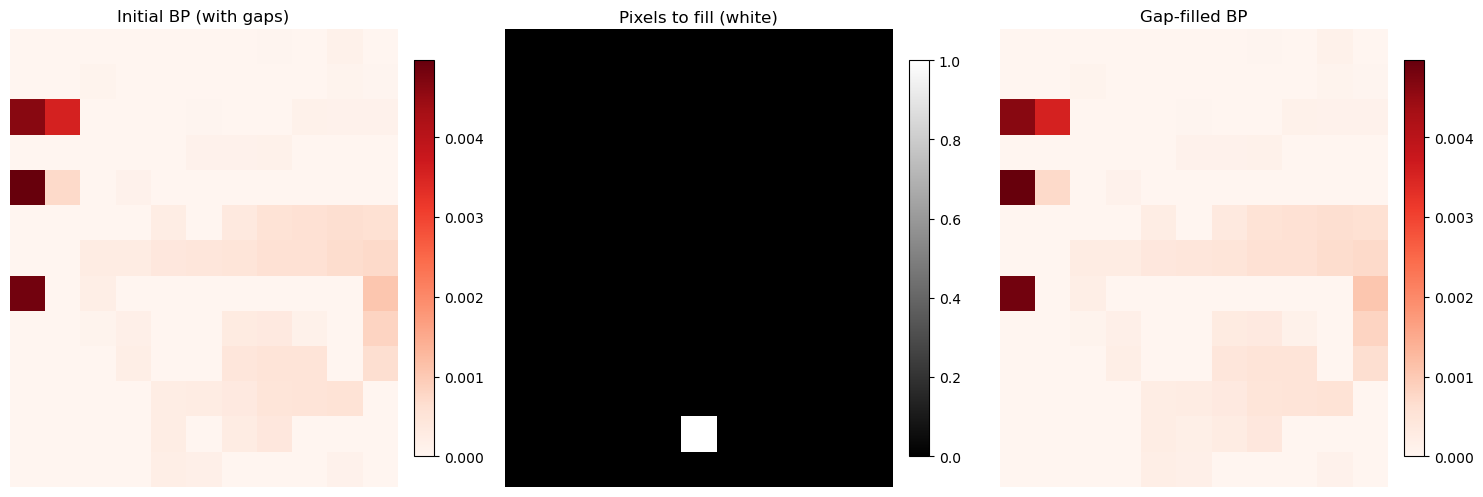

In [18]:
import matplotlib.pyplot as plt
import xarray as xr

# Step 01: Gap Filling - capture initial, intermediate, and final states
with xr.set_options(arithmetic_join='exact'):
    # Initial state
    initial_bp = riley_2011_270m_5070_subset['BP'].copy()

    # Identify pixels to fill
    valid_pixels = riley_2011_270m_5070_subset['BP'] > 0
    surrounded_by_four_valid_values = (
        valid_pixels.shift(x=1)
        + valid_pixels.shift(x=-1)
        + valid_pixels.shift(y=1)
        + valid_pixels.shift(y=-1)
    ) == 4
    nans_surrounded_by_four_valid_values = xr.where(
        (valid_pixels == 0) & surrounded_by_four_valid_values, 1, 0
    )

    # Create rolling mean
    rolling_mean = riley_2011_270m_5070_subset.rolling(
        {'x': 3, 'y': 3}, center=True, min_periods=1
    ).mean(skipna=True)

    # Final gap-filled state
    gap_filled_bp = xr.where(
        nans_surrounded_by_four_valid_values, rolling_mean, riley_2011_270m_5070_subset
    )['BP']

# Plot Step 01: Three stages of gap filling
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Initial with gaps
im1 = axes[0].imshow(initial_bp.values, cmap='Reds', vmin=0, vmax=initial_bp.max())
axes[0].set_title('Initial BP (with gaps)', fontsize=12)
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Mask showing pixels to be filled
im2 = axes[1].imshow(nans_surrounded_by_four_valid_values.values, cmap='gray', vmin=0, vmax=1)
axes[1].set_title('Pixels to fill (white)', fontsize=12)
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

# Final gap-filled
im3 = axes[2].imshow(gap_filled_bp.values, cmap='Reds', vmin=0, vmax=initial_bp.max())
axes[2].set_title('Gap-filled BP', fontsize=12)
axes[2].axis('off')
fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [19]:
# Create dataset with 'stage' dimension
step01_data = xr.concat([initial_bp, gap_filled_bp], dim='stage').assign_coords(
    stage=['initial', 'gap_filled']
)

# Add the mask as a separate variable
step01_ds = xr.Dataset(
    {'burn_probability': step01_data, 'pixels_to_fill': nans_surrounded_by_four_valid_values}
).pipe(set_zarr_encoding)

step01_ds.to_zarr(
    's3://carbonplan-ocr/output/fire-risk/tensor/web-figures/methods-step01-gap-filling-270m-5070.zarr',
    zarr_format=2,
    consolidated=True,
    mode='w',
)

step01_ds

<xarray.Dataset> Size: 4kB
Dimensions:           (x: 11, y: 13, stage: 2)
Coordinates:
  * x                 (x) float64 88B -7.749e+05 -7.746e+05 ... -7.722e+05
  * y                 (y) float64 104B 1.917e+06 1.917e+06 ... 1.92e+06 1.92e+06
  * stage             (stage) <U10 80B 'initial' 'gap_filled'
    spatial_ref       int32 4B 5070
Data variables:
    burn_probability  (stage, y, x) float64 2kB 0.0 0.0 0.0 ... 0.0 0.0001 0.0
    pixels_to_fill    (y, x) int64 1kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

# Step 02: Wind Direction Distribution

Extract and visualize the 8-direction wind probability distribution for a single pixel at Marshall Fire center.

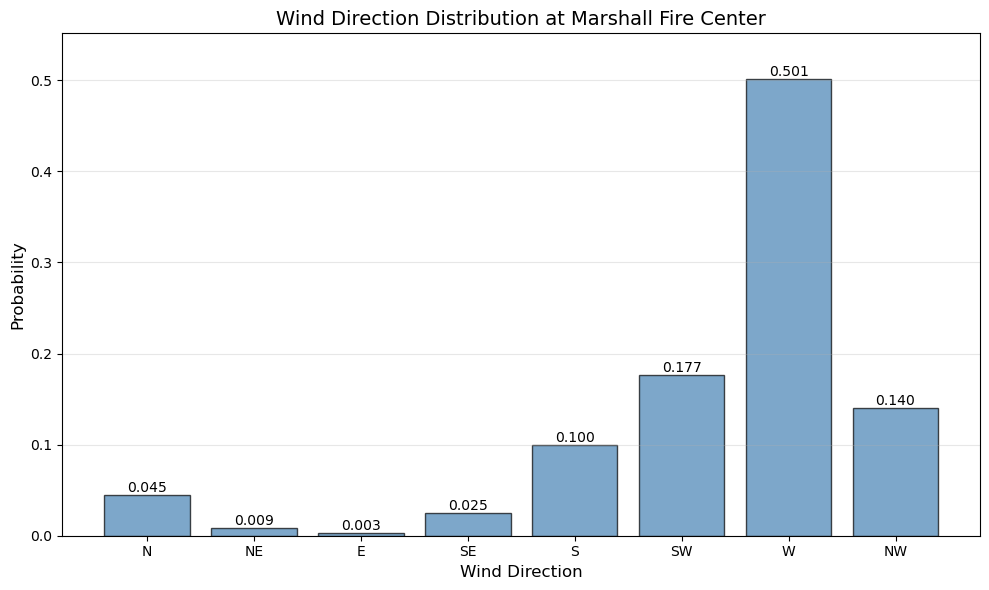

Wind distribution sum: 1.0000


In [20]:
# Extract wind direction distribution at Marshall Fire center
center_lat_idx = len(wind_direction_distribution_30m_4326.latitude) // 2
center_lon_idx = len(wind_direction_distribution_30m_4326.longitude) // 2

center_wind_dist = wind_direction_distribution_30m_4326.isel(
    latitude=center_lat_idx, longitude=center_lon_idx
).values

direction_labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']

# Plot Step 02: Wind direction distribution
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(direction_labels, center_wind_dist, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('Wind Direction', fontsize=12)
ax.set_ylabel('Probability', fontsize=12)
ax.set_title('Wind Direction Distribution at Marshall Fire Center', fontsize=14)
ax.set_ylim(0, max(center_wind_dist) * 1.1)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars, center_wind_dist):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f'{val:.3f}',
        ha='center',
        va='bottom',
        fontsize=10,
    )

plt.tight_layout()
plt.show()

print(f'Wind distribution sum: {center_wind_dist.sum():.4f}')

In [21]:
wind_direction_distribution_30m_4326

<xarray.DataArray 'wind_direction_distribution' (latitude: 100, longitude: 100,
                                                 wind_direction: 8)> Size: 320kB
array([[[0.04482759, 0.00875332, 0.00265252, ..., 0.17692308,
         0.50132626, 0.1403183 ],
        [0.04482759, 0.00875332, 0.00265252, ..., 0.17692308,
         0.50132626, 0.1403183 ],
        [0.04482759, 0.00875332, 0.00265252, ..., 0.17692308,
         0.50132626, 0.1403183 ],
        ...,
        [0.04482759, 0.00875332, 0.00265252, ..., 0.17692308,
         0.50132626, 0.1403183 ],
        [0.04482759, 0.00875332, 0.00265252, ..., 0.17692308,
         0.50132626, 0.1403183 ],
        [0.04482759, 0.00875332, 0.00265252, ..., 0.17692308,
         0.50132626, 0.1403183 ]],

       [[0.04482759, 0.00875332, 0.00265252, ..., 0.17692308,
         0.50132626, 0.1403183 ],
        [0.04482759, 0.00875332, 0.00265252, ..., 0.17692308,
         0.50132626, 0.1403183 ],
        [0.04482759, 0.00875332, 0.00265252, ..., 0.17692308,
         0.50132626, 0.1403183 ],
...
        [0.05411141, 0.01034483, 0.00530504, ..., 0.16657825,
         0.5220159 , 0.10742705],
        [0.05411141, 0.01034483, 0.00530504, ..., 0.16657825,
         0.5220159 , 0.10742705],
        [0.05411141, 0.01034483, 0.00530504, ..., 0.16657825,
         0.5220159 , 0.10742705]],

       [[0.05411141, 0.01034483, 0.00530504, ..., 0.16657825,
         0.5220159 , 0.10742705],
        [0.05411141, 0.01034483, 0.00530504, ..., 0.16657825,
         0.5220159 , 0.10742705],
        [0.05411141, 0.01034483, 0.00530504, ..., 0.16657825,
         0.5220159 , 0.10742705],
        ...,
        [0.05411141, 0.01034483, 0.00530504, ..., 0.16657825,
         0.5220159 , 0.10742705],
        [0.05411141, 0.01034483, 0.00530504, ..., 0.16657825,
         0.5220159 , 0.10742705],
        [0.05411141, 0.01034483, 0.00530504, ..., 0.16657825,
         0.5220159 , 0.10742705]]], shape=(100, 100, 8), dtype=float32)
Coordinates:
  * latitude     (latitude) float64 800B 39.93 39.93 39.94 ... 39.96 39.96 39.97
  * longitude    (longitude) float64 800B -105.2 -105.2 -105.2 ... -105.1 -105.1
    crs          int64 8B 1
    quantile     float64 8B 0.99
    spatial_ref  int32 4B 4326
Dimensions without coordinates: wind_direction
Attributes:
    long_name:    Wind direction distribution during fire-weather hours
    units:        probability
    description:  Fraction of hours in each of 8 cardinal and ordinal directi...

In [22]:
step02_ds = wind_direction_distribution_30m_4326.to_dataset().pipe(set_zarr_encoding)

step02_ds.to_zarr(
    's3://carbonplan-ocr/output/fire-risk/tensor/web-figures/methods-step02-wind-distribution-30m-4326.zarr',
    zarr_format=2,
    consolidated=True,
    mode='w',
)

step02_ds

<xarray.Dataset> Size: 322kB
Dimensions:                      (latitude: 100, longitude: 100,
                                  wind_direction: 8)
Coordinates:
  * latitude                     (latitude) float64 800B 39.93 39.93 ... 39.97
  * longitude                    (longitude) float64 800B -105.2 ... -105.1
    crs                          int64 8B 1
    quantile                     float64 8B 0.99
    spatial_ref                  int32 4B 4326
Dimensions without coordinates: wind_direction
Data variables:
    wind_direction_distribution  (latitude, longitude, wind_direction) float32 320kB ...

# Step 03: Spreading Burn Probability According to Wind Direction

Capture and visualize progressive spreading iterations (Q0 → Q1 → Q2 → Q3 → FINAL).

In [23]:
from odc.geo.xr import xr_reproject

from ocr.risks.fire import create_weighted_composite_bp_map

# Prepare data: reproject gap-filled Riley to 30m 4326
wind_direction_distribution_30m_4326_assigned = assign_crs(
    wind_direction_distribution_30m_4326, 'EPSG:4326'
)
gap_filled_bp_assigned = assign_crs(gap_filled_bp, 'EPSG:5070')

target_geobox = wind_direction_distribution_30m_4326_assigned.odc.geobox
riley_30m_4326_reprojected = xr_reproject(
    gap_filled_bp_assigned.to_dataset(name='BP'),
    how=target_geobox,
    resampling='nearest',
)['BP']

riley_30m_4326_reprojected = riley_30m_4326_reprojected.assign_coords(
    {
        'latitude': wind_direction_distribution_30m_4326_assigned.latitude,
        'longitude': wind_direction_distribution_30m_4326_assigned.longitude,
    }
)

# Get snapshots of convolution iterations
snapshots = apply_wind_directional_convolution_with_snapshots(
    riley_30m_4326_reprojected, iterations=3
)

# Create weighted composite for each snapshot
weighted_snapshots = {}
for key, snapshot_ds in snapshots.items():
    weighted_bp = create_weighted_composite_bp_map(
        snapshot_ds, wind_direction_distribution_30m_4326_assigned
    )
    weighted_snapshots[key] = weighted_bp

print(f'Created snapshots: {list(weighted_snapshots.keys())}')

Created snapshots: ['Q0', 'Q1', 'Q2', 'Q3']


/tmp/ipykernel_1960/1074419174.py:59: RuntimeWarning: invalid value encountered in divide
  arr = np.where(convolved_mask > 0, convolved_arr / convolved_mask, 0.0)


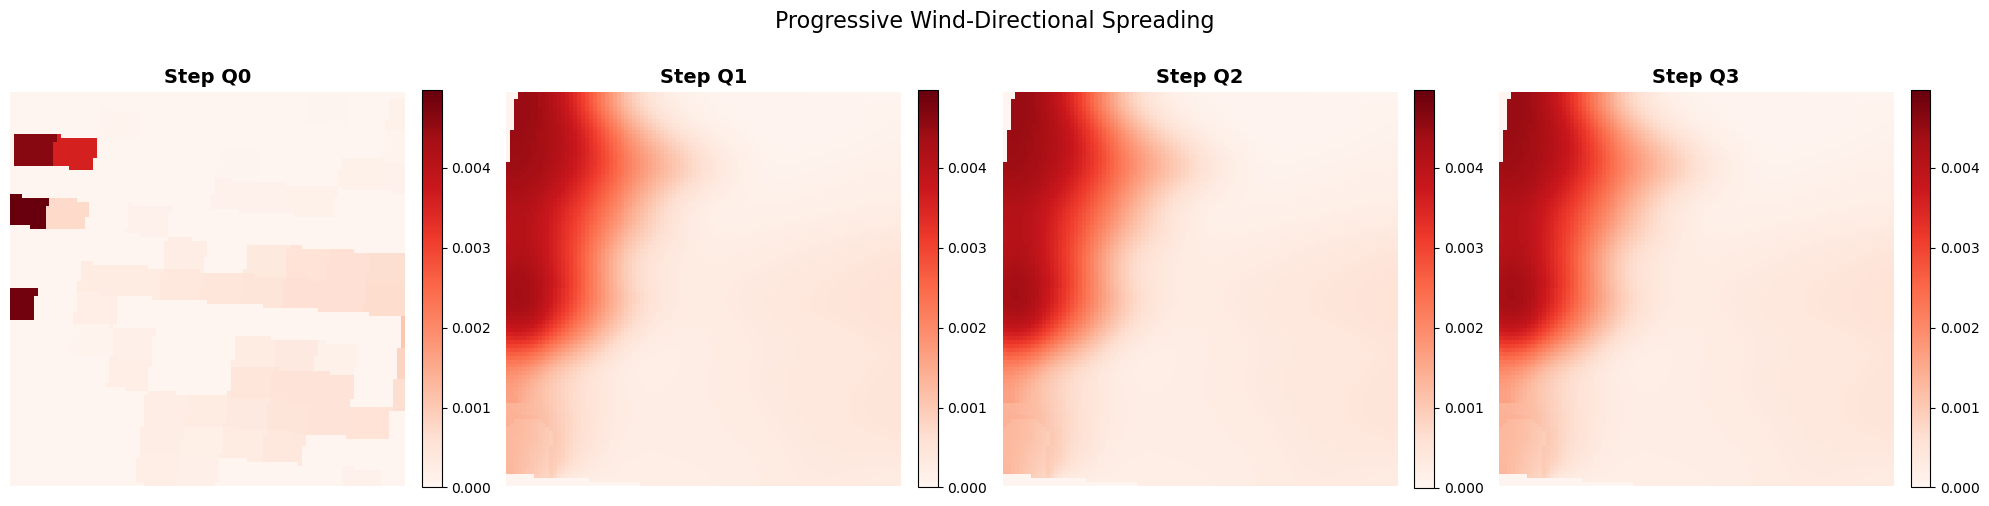

In [24]:
# Plot Step 03: Progressive spreading (Q0 → Q1 → Q2 → Q3)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Find common vmin/vmax for consistent color scaling
all_values = [weighted_snapshots[f'Q{i}'].values for i in range(4)]
vmin = 0
vmax = np.nanmax([np.nanmax(v) for v in all_values])

for i, ax in enumerate(axes):
    snapshot_key = f'Q{i}'
    data = weighted_snapshots[snapshot_key]

    im = ax.imshow(data.values, cmap='Reds', vmin=vmin, vmax=vmax)
    ax.set_title(f'Step {snapshot_key}', fontsize=14, fontweight='bold')
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle('Progressive Wind-Directional Spreading', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [25]:
# Stack Q0 -> Q3 along 'iteration' dimension
step03_data = xr.concat(
    [
        weighted_snapshots['Q0'],
        weighted_snapshots['Q1'],
        weighted_snapshots['Q2'],
        weighted_snapshots['Q3'],
    ],
    dim='iteration',
).assign_coords(iteration=['Q0', 'Q1', 'Q2', 'Q3'])

step03_ds = step03_data.to_dataset(name='burn_probability').pipe(set_zarr_encoding)

step03_ds.to_zarr(
    's3://carbonplan-ocr/output/fire-risk/tensor/web-figures/methods-step03-spreading-iterations-30m-4326.zarr',
    zarr_format=2,
    consolidated=True,
    mode='w',
)
step03_ds

<xarray.Dataset> Size: 322kB
Dimensions:           (latitude: 100, longitude: 100, iteration: 4)
Coordinates:
  * latitude          (latitude) float64 800B 39.93 39.93 39.94 ... 39.96 39.97
  * longitude         (longitude) float64 800B -105.2 -105.2 ... -105.1 -105.1
  * iteration         (iteration) <U2 32B 'Q0' 'Q1' 'Q2' 'Q3'
    spatial_ref       int32 4B 4326
    crs               int64 8B 1
    quantile          float64 8B 0.99
Data variables:
    burn_probability  (iteration, latitude, longitude) float64 320kB 0.0 ... ...

# Step 04: Localized Blurring

Apply Gaussian blur to smooth the final burn probability map.

In [26]:
import cv2 as cv

# Apply Gaussian blur to Q3 (final convolution state)
q3_data = weighted_snapshots['Q3']

# Combine with original Riley data (fill zeros with wind-smeared values)
wind_informed_bp_combined = xr.where(
    riley_30m_4326_reprojected == 0, q3_data, riley_30m_4326_reprojected
)

# Apply Gaussian blur
smoothed_bp = xr.apply_ufunc(
    cv.GaussianBlur,
    wind_informed_bp_combined.chunk(latitude=-1, longitude=-1),
    input_core_dims=[['latitude', 'longitude']],
    output_core_dims=[['latitude', 'longitude']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[np.float32],
    kwargs={'ksize': (25, 25), 'sigmaX': 0},
)

print('Gaussian blur applied to final burn probability')

Gaussian blur applied to final burn probability


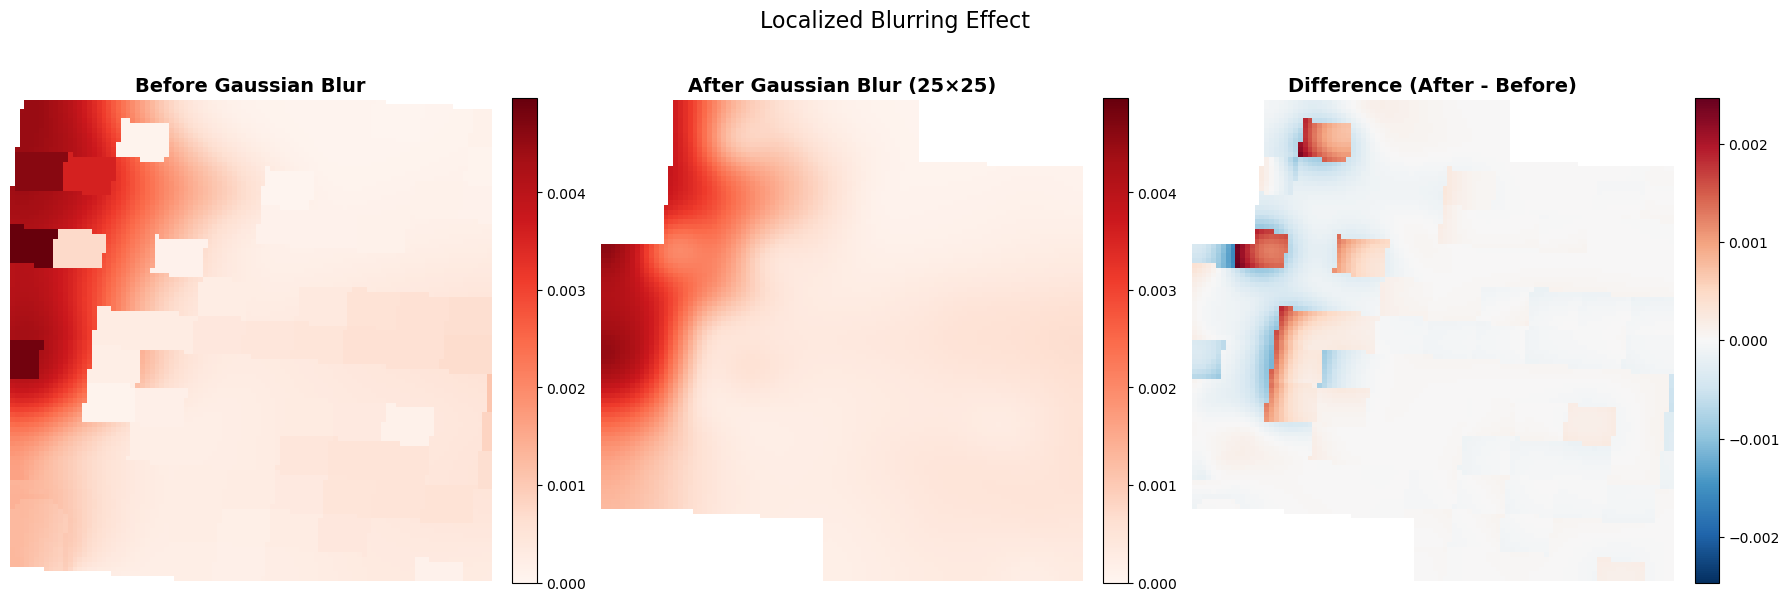

In [27]:
# Plot Step 04: Before and after Gaussian blur
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Find common vmin/vmax
vmin = 0
vmax = max(np.nanmax(wind_informed_bp_combined.values), np.nanmax(smoothed_bp.values))

# Before blur (Q3 combined with original)
im1 = axes[0].imshow(wind_informed_bp_combined.values, cmap='Reds', vmin=vmin, vmax=vmax)
axes[0].set_title('Before Gaussian Blur', fontsize=14, fontweight='bold')
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# After blur
im2 = axes[1].imshow(smoothed_bp.values, cmap='Reds', vmin=vmin, vmax=vmax)
axes[1].set_title('After Gaussian Blur (25×25)', fontsize=14, fontweight='bold')
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

# Difference (smoothed - original)
diff = smoothed_bp.values - wind_informed_bp_combined.values
vmax_diff = max(abs(np.nanmin(diff)), abs(np.nanmax(diff)))
im3 = axes[2].imshow(diff, cmap='RdBu_r', vmin=-vmax_diff, vmax=vmax_diff)
axes[2].set_title('Difference (After - Before)', fontsize=14, fontweight='bold')
axes[2].axis('off')
fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

plt.suptitle('Localized Blurring Effect', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [28]:
step04_data = xr.concat([wind_informed_bp_combined, smoothed_bp], dim='stage').assign_coords(
    stage=['before_blur', 'after_blur']
)

step04_ds = step04_data.to_dataset(name='burn_probability').chunk(stage=-1).pipe(set_zarr_encoding)

step04_ds.to_zarr(
    's3://carbonplan-ocr/output/fire-risk/tensor/web-figures/methods-step04-gaussian-blur-30m-4326.zarr',
    zarr_format=2,
    consolidated=True,
    mode='w',
)
step04_ds

<xarray.Dataset> Size: 162kB
Dimensions:           (latitude: 100, longitude: 100, stage: 2)
Coordinates:
  * latitude          (latitude) float64 800B 39.93 39.93 39.94 ... 39.96 39.97
  * longitude         (longitude) float64 800B -105.2 -105.2 ... -105.1 -105.1
  * stage             (stage) <U11 88B 'before_blur' 'after_blur'
    spatial_ref       int32 4B 4326
    crs               int64 8B 1
    quantile          float64 8B 0.99
Data variables:
    burn_probability  (stage, latitude, longitude) float64 160kB dask.array<chunksize=(2, 100, 100), meta=np.ndarray>